<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/CNN_513.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 513
Start with CNN 304 which uses Conv1D layers.

No need for K-mers with convolution. End reliance on make_kmers().

Filters slightly execeeded Dense Neurons 




In [40]:
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='CNN513'  
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=100
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=2
FILTERS=50
KERNEL=3
NEURONS=40
DROP=0.4
ACT="tanh"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [43]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    SHAPE=(1000,5)  # 1000 time steps, 5 features
    clayer1 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same",
                                 input_shape=SHAPE)
    clayer2 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer3 = keras.layers.MaxPooling1D(2)
    clayer4 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer5 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer6 = keras.layers.MaxPooling1D(2)
    clayer7 = keras.layers.Flatten()

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt, input_shape=[1000])
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    cnn = keras.models.Sequential()
    cnn.add(clayer1)
    cnn.add(clayer2)
    cnn.add(clayer3)
    cnn.add(clayer4)
    cnn.add(clayer5)
    cnn.add(clayer6)
    cnn.add(clayer7)
    cnn.add(dlayer1)
    cnn.add(dlayer2)
    cnn.add(dlayer3)
    cnn.add(dlayer4)
    cnn.add(output_layer)
    mlpc = compile_model(cnn)
    return mlpc

Cross validation

In [44]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [45]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 1000, 50)          800       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1000, 50)          7550      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 500, 50)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 500, 50)           7550      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 500, 50)           7550      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 250, 50)           0         
___________________________________________________________

In [46]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=tools.make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
(X1,y_train)=tools.separate_X_and_y(subset)
# X1 is pandas df of ("list" of one sequence)
X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
X3=[elem[0] for elem in X2]  # numpy dnarray of str
X4=tools.uniform_length(X3,MAXLEN)
X5= [tools.one_hot(x) for x in X4]
X_train=np.asarray(X5)
y_train=y_train.to_numpy()

subset=None
X1=None
X2=None
X3=None
X4=None
X5=None

Load data from files.
Ready: train_set


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 3s 6ms/step - loss: 0.6279 - accuracy: 0.6784 - val_loss: 0.5406 - val_accuracy: 0.7294
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.1.best/assets
Epoch 2/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5859 - accuracy: 0.7018 - val_loss: 0.5187 - val_accuracy: 0.7455
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.1.best/assets
Epoch 3/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5649 - accuracy: 0.7079 - val_loss: 0.5121 - val_accuracy: 0.7498
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.1.best/assets
Epoch 4/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5543 - accuracy: 0.7201 - val_loss: 0.6111 - val_accuracy: 0.7132
Epoch 5/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5515 - accuracy: 0.7262 - val_loss: 0.5154 -

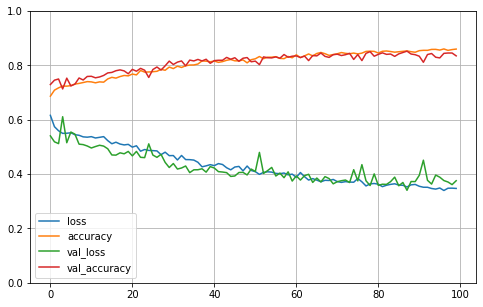

accuracy: 85.23%
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 3s 6ms/step - loss: 0.6706 - accuracy: 0.6479 - val_loss: 0.5640 - val_accuracy: 0.7126
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.2.best/assets
Epoch 2/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5941 - accuracy: 0.6901 - val_loss: 0.5576 - val_accuracy: 0.7157
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.2.best/assets
Epoch 3/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5709 - accuracy: 0.7091 - val_loss: 0.5440 - val_accuracy: 0.7325
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.2.best/assets
Epoch 4/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5661 - accuracy: 0.7129 - val_loss: 0.5605 - val_accuracy: 0.7337
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.2.best/assets
Epoch 5/100
453/453 [===========

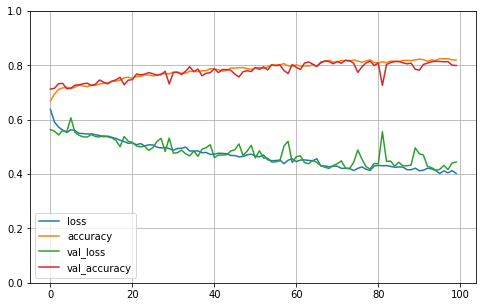

accuracy: 81.87%
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 3s 6ms/step - loss: 0.6453 - accuracy: 0.6634 - val_loss: 0.5516 - val_accuracy: 0.7225
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.3.best/assets
Epoch 2/100
453/453 [==============================] - 3s 6ms/step - loss: 0.5915 - accuracy: 0.6932 - val_loss: 0.5634 - val_accuracy: 0.7318
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.3.best/assets
Epoch 3/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5735 - accuracy: 0.7169 - val_loss: 0.5562 - val_accuracy: 0.7114
Epoch 4/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5761 - accuracy: 0.6936 - val_loss: 0.5371 - val_accuracy: 0.7312
Epoch 5/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5641 - accuracy: 0.7198 - val_loss: 0.5559 - val_accuracy: 0.7151
Epoch 6/100
453/453 [==============================] - 2s 5ms/ste

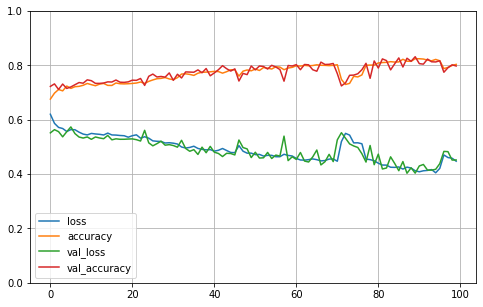

accuracy: 83.18%
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 3s 6ms/step - loss: 0.6826 - accuracy: 0.6347 - val_loss: 0.5793 - val_accuracy: 0.7126
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.4.best/assets
Epoch 2/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5813 - accuracy: 0.7020 - val_loss: 0.5399 - val_accuracy: 0.7418
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.4.best/assets
Epoch 3/100
453/453 [==============================] - 3s 6ms/step - loss: 0.5717 - accuracy: 0.7134 - val_loss: 0.5368 - val_accuracy: 0.7331
Epoch 4/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5629 - accuracy: 0.7149 - val_loss: 0.5377 - val_accuracy: 0.7424
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.4.best/assets
Epoch 5/100
453/453 [==============================] - 3s 6ms/step - loss: 0.5560 - accuracy: 0.7181 - val_loss: 0.5715 

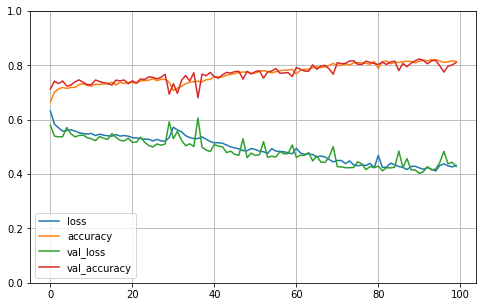

accuracy: 82.37%
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 3s 6ms/step - loss: 0.6675 - accuracy: 0.6455 - val_loss: 0.5503 - val_accuracy: 0.7263
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.5.best/assets
Epoch 2/100
453/453 [==============================] - 3s 6ms/step - loss: 0.6017 - accuracy: 0.6893 - val_loss: 0.5341 - val_accuracy: 0.7343
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN513.cv.5.best/assets
Epoch 3/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5771 - accuracy: 0.7032 - val_loss: 0.5536 - val_accuracy: 0.7070
Epoch 4/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5678 - accuracy: 0.7173 - val_loss: 0.5412 - val_accuracy: 0.7169
Epoch 5/100
453/453 [==============================] - 2s 5ms/step - loss: 0.5562 - accuracy: 0.7215 - val_loss: 0.5325 - val_accuracy: 0.7467
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/C

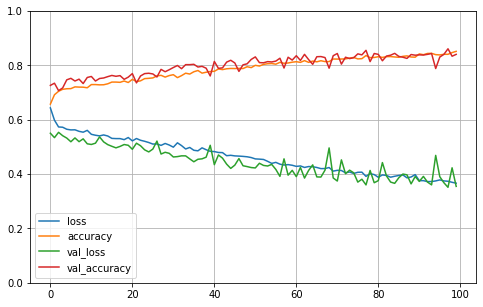

accuracy: 86.10%

5-way Cross Validation mean 83.75% (+/- 1.64%)
Done


In [47]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")